# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: 206019705, 208253542

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import itertools

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import itertools

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [4]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

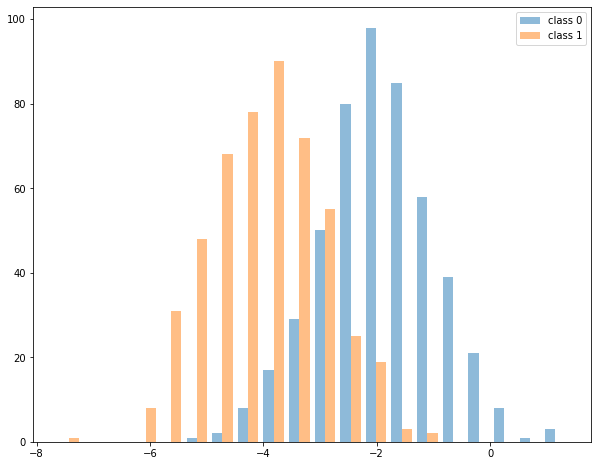

In [5]:
# For first feature only (1)
first1000_training = training_set[:1000]
cls0_1000 = first1000_training[first1000_training['y'] == 0]['x1'].values
cls1_1000 = first1000_training[first1000_training['y'] == 1]['x1'].values
plt.hist([cls0_1000,cls1_1000], bins=20, alpha=0.5)
plt.legend(['class 0', 'class 1'])
plt.show()

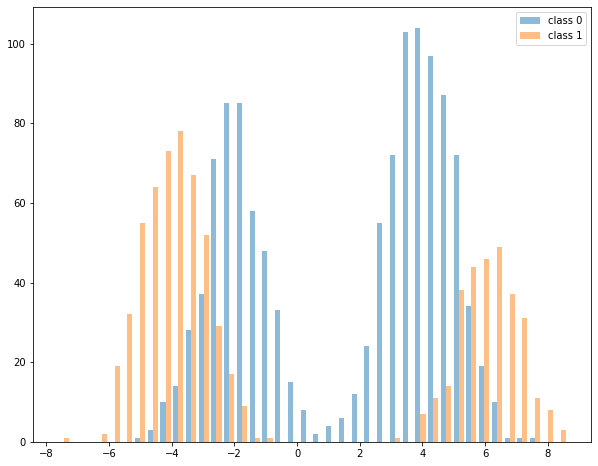

In [6]:
#For the first feature only: (2)
cls0_all = training_set[training_set['y'] == 0]['x1'].values
cls1_all = training_set[training_set['y'] == 1]['x1'].values
plt.hist([cls0_all, cls1_all], bins=40, alpha=0.5)
plt.legend(['class 0', 'class 1'])
plt.show()

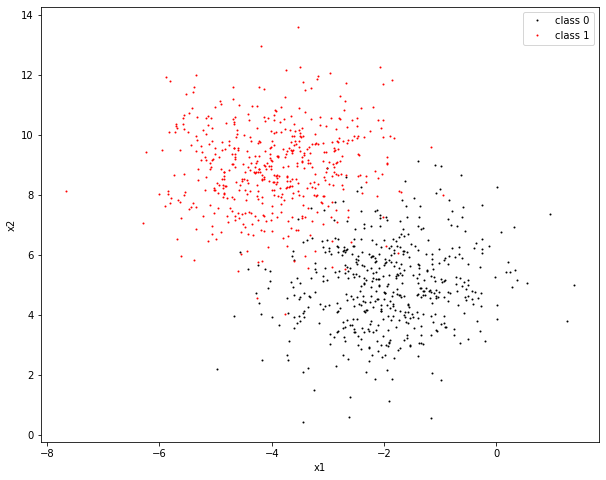

In [7]:
# For both features only (1)
first_1000_mat = training_set[:1000].values
cls0_mat_1000 = np.array([vec for vec in first_1000_mat if vec[2] == 0])
cls1_mat_1000 = np.array([vec for vec in first_1000_mat if vec[2] == 1])
plt.plot(cls0_mat_1000[:, 0], cls0_mat_1000[:, 1], 'ro', ms=1, mec='k')
plt.plot(cls1_mat_1000[:, 0], cls1_mat_1000[:, 1], 'ro', ms=1)
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['class 0', 'class 1'])
plt.show()

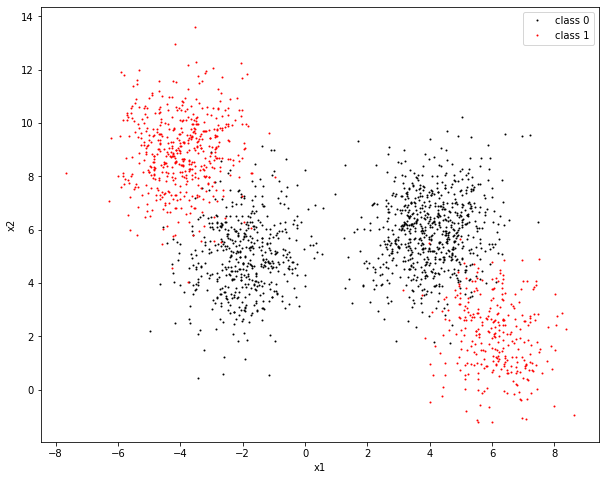

In [8]:
# For both features only (2)
all_mat = training_set.values
cls0_mat = np.array([vec for vec in all_mat if vec[2] == 0])
cls1_mat = np.array([vec for vec in all_mat if vec[2] == 1])
plt.plot(cls0_mat[:, 0], cls0_mat[:, 1], 'ro', ms=1, mec='k')
plt.plot(cls1_mat[:, 0], cls1_mat[:, 1], 'ro', ms=1)
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(["class 0", "class 1"])
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [9]:
def compute_cost(X, y, theta):
    h = sigmoid(X, theta)
    return np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h)) / X[0].shape

def sigmoid(X, theta):
    return 1 / (1 + np.exp(-X.dot(theta)))

def update_theta(X, y, theta, rate):
    return theta - (rate * (X.T).dot((sigmoid(X, theta) -y))) 


In [10]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = []
        self.cost_list = [] # list history cost for each iteration

        

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        # bias trick
        w_0 = np.ones(X.shape[0])
        X = np.column_stack((w_0, X))

        # random weights for each feature
        np.random.seed(self.random_state)
        theta = np.random.random(size=X.shape[1])

        cost_list = []
        for _ in range(self.n_iter):
          cost_list.append(compute_cost(X, y, theta))
          theta = update_theta(X, y, theta, self.eta)
          
          if len(cost_list) > 1 and (cost_list[-2] - cost_list[-1]) < self.eps:
            break
        
        self.theta = theta
        self.cost_list = cost_list
    
    def predict(self, X):
        """Return the predicted class label"""
        w_0 = np.ones(X.shape[0])
        X = np.column_stack((w_0, X))
        return np.array([1 if sigmoid(X[i], self.theta) > 0.5 else 0 for i in range(len(X))])
                


In [11]:
def fold_acc(split_X, split_Y, k, alpha, eps):
    acc_list = []
    
    for i in range(k):
        lr_GD = LogisticRegressionGD(eta = alpha, eps = eps)
        
        temp_train_X, temp_train_Y = np.concatenate(np.delete(split_X, i, 0)), np.concatenate(np.delete(split_Y, i, 0))
        temp_test_X, temp_test_Y = split_X_train[i], split_Y_train[i]

        lr_GD.fit(temp_train_X, temp_train_Y)
        
        temp_predict = lr_GD.predict(temp_test_X)
        
        acc_list.append(np.sum(temp_test_Y == temp_predict) / len(temp_test_Y))
       
    return np.array(acc_list).mean()

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [12]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

k = 5

best_alpha, best_eps, max_acc = 0, 0, 0 

train_shuffle = training_set.sample(frac=1)

X_train_shuffle, y_train_shuffle = train_shuffle[['x1', 'x2']].values, train_shuffle['y'].values

split_X_train, split_Y_train = np.array(np.array_split(X_train_shuffle, k)), np.array(np.array_split(y_train_shuffle, k))

for alpha, eps in itertools.product(etas, epss):
    mean_acc = fold_acc(split_X_train, split_Y_train, k, alpha, eps)
    
    if mean_acc > max_acc:
        best_alpha, best_eps, max_acc = alpha, eps, mean_acc
        
print(best_alpha, best_eps, max_acc)



5e-05 1e-06 0.82


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [13]:
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    numerator = np.power(np.e, -0.5 * np.power(((data - mu)/sigma), 2))
    denominator = sigma * np.power(2 * np.pi, 0.5)
    return numerator / denominator

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [14]:
def compute_costs(data, mu, sigma, w, k):
    cost = 0
    for i in range(k):
        cost += w[i] * norm_pdf(data, mu[i], sigma[i])
    
    return np.sum(-np.log(cost))

In [15]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=1):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.ws = []
        self.mus = []
        self.sigmas = []
        

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        number_davisions_data = (int)(data.shape[0] / self.k)
        start_index = 0
        end_index = number_davisions_data

        for i in range(self.k):
          if i == self.k - 1:
            data_i = data[start_index : ]
            self.ws.append(1/self.k)
            self.mus.append(data_i.mean())
            self.sigmas.append(data_i.std())
          else:
            data_i = data[start_index : end_index]
            self.ws.append(1/self.k)
            self.mus.append(data_i.mean())
            self.sigmas.append(data_i.std())

          # data_i = data[start_index : end_index]
          # self.ws.append(1/self.k)
          # self.mus.append(data_i.mean())
          # self.sigmas.append(data_i.std())

          start_index = end_index
          end_index += number_davisions_data
        # self.ws = np.random.random(self.k)
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        likelihoods = [self.ws[i] * norm_pdf(data, self.mus[i], self.sigmas[i]) for i in range(self.k)]
        dev = sum(likelihoods)
        return [likelihood / dev for likelihood in likelihoods]

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        responsibilities = self.expectation(data)

        for i in range(self.k):
            self.ws[i] = responsibilities[i].mean()
            self.mus[i] = (responsibilities * data).mean() * (1/self.ws[i])
            self.sigmas[i] = np.sqrt((responsibilities * np.square(data - self.mus[i])).mean() * (1/self.ws[i]))


    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        # init parameters
        self.init_params(data)
        J_history = []

        for j in range(self.n_iter):
          cost = compute_costs(data, self.mus, self.sigmas, self.ws, self.k)
          self.maximization(data)

          if j > 0 and np.absolute(J_history[-1] - cost) < self.eps:
            break

          J_history.append(cost)

    def get_dist_params(self):
        return self.mus, self.sigmas, self.ws
    

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [16]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, random_state=1):
      self.k = k
      self.emX1 = [EM(k=self.k) for _ in range(2)]
      self.emX2 = [EM(k=self.k) for _ in range(2)]
      self.priors = [0,0]

    def fit(self, X, y):
      """ 
      Fit training data.

      Parameters
      ----------
      X : array-like, shape = [n_examples, n_features]
        Training vectors, where n_examples is the number of examples and
        n_features is the number of features.
      y : array-like, shape = [n_examples]
        Target values.
      """
      data = np.column_stack([X,y])
      self.prior(data)
      for class_value in range(2):
        class_data = data[data[:, -1] == class_value]
        self.emX1[class_value].fit(class_data[:,0])
        self.emX2[class_value].fit(class_data[:,1])
        
    
    def predict(self, X):
      """Return the predicted class label"""
      predictions = []
      for row in X:
          predict_0, predict_1 = self.posterior(row)
          if(predict_0 > predict_1):
              predictions.append(0)
          else:
              predictions.append(1)
              
      return np.asarray(predictions)

    def prior(self, data):
      number_instances = data.shape[0]
      for i in range(data.shape[1] - 1):
        class_i = [i for j in range(number_instances) if data[j][2] == i]
        self.priors[i] = len(class_i) / number_instances        

    def likelihood(self, x, j):
      likelihood_x1 = sum([self.emX1[j].ws[i] * norm_pdf(x[0], self.emX1[j].mus[i], self.emX1[j].sigmas[i]) for i in range(self.k)])
      likelihood_x2 = sum([self.emX2[j].ws[i] * norm_pdf(x[1], self.emX2[j].mus[i], self.emX2[j].sigmas[i]) for i in range(self.k)])
      return likelihood_x1 * likelihood_x2

    def posterior(self, x):
      return (self.likelihood(x,0) * self.priors[0]), (self.likelihood(x,1) * self.priors[1])


## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [17]:
def accuracy_evaluation(X , y, classifier):
    prediction_res = y - classifier.predict(X)
    prediction = len(prediction_res) - np.count_nonzero(prediction_res)

    return (prediction/ len(X)) * 100

Logistic Regression -> for the training data the accuracy is  96.5  for the test data the accuracy is  93.8
Naive Bayes -> for the training data the accuracy is  96.6  for the test data the accuracy is  94.19999999999999


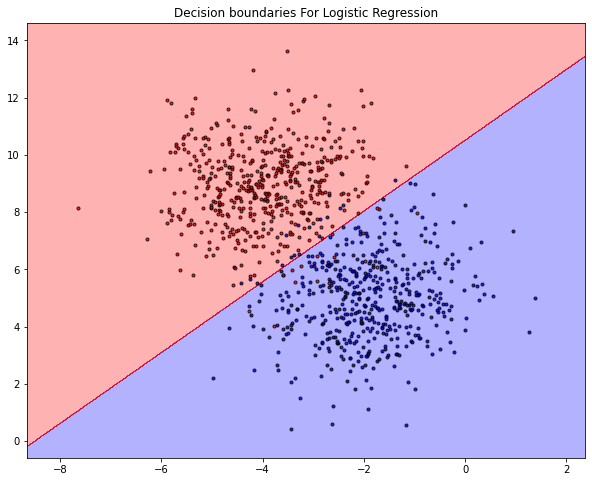

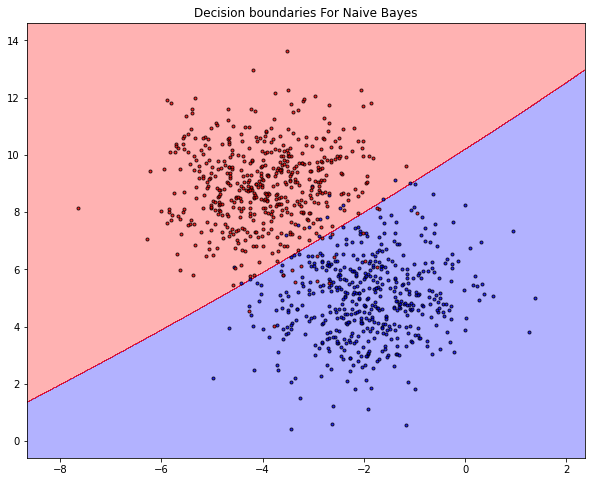

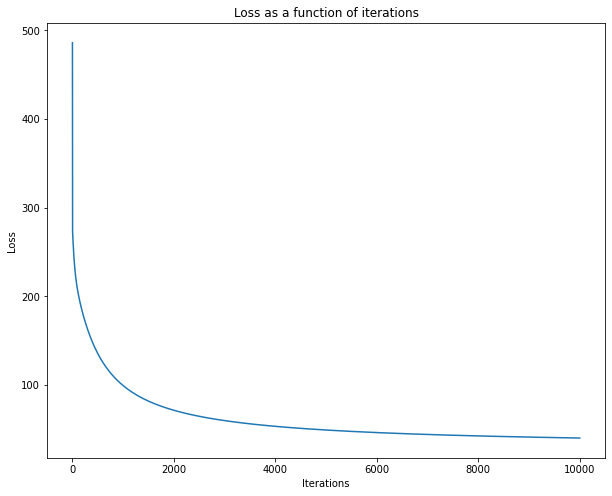

In [18]:
# 1000 samples for the training data and 500 samples for the test data
# creating datasets
X_training_1000, y_training_1000 = X_training[:1000], y_training[:1000]
X_test_500, y_test_500 = X_test[:500], y_test[:500]

# fit Logistic Regression model
LR = LogisticRegressionGD(eta=best_alpha, eps=best_eps)
LR.fit(X_training_1000, y_training_1000)

# fit Naive Bayes model
NB = NaiveBayesGaussian(k=2)
NB.fit(X_training_1000, y_training_1000)

# Logistic Regression -> accuracy evaluation (train)
train_acc_LG = accuracy_evaluation(X_training_1000, y_training_1000, LR)

# Logistic Regression -> accuracy evaluation (test)
test_acc_LG = accuracy_evaluation(X_test_500, y_test_500, LR)

# Naive Bayes -> accuracy evaluation (train)
train_acc_NB = accuracy_evaluation(X_training_1000, y_training_1000, NB)

# Naive Bayes -> accuracy evaluation (test)
test_acc_NB = accuracy_evaluation(X_test_500, y_test_500, NB)

print("Logistic Regression -> for the training data the accuracy is ", train_acc_LG, " for the test data the accuracy is ", test_acc_LG)
print("Naive Bayes -> for the training data the accuracy is ", train_acc_NB, " for the test data the accuracy is ", test_acc_NB)

# introduce diagrams for part of the data (1000 samples for the training data and 500 samples for the test data)
# explanation: We can observe the 2 gaussians in our first 1000 points of training data and a clear linear separator that LOR algorithem yields.
plt.title("Decision boundaries For Logistic Regression")
plot_decision_regions(X_training_1000, y_training_1000, LR)
plt.figure()

# explanation: We can observe the 2 gaussians in our first 1000 points of training data. NB is a classifier so it is capble of yielding linear and non-linear separators.
# in this case, a linear separator was enough
plt.title("Decision boundaries For Naive Bayes")
plot_decision_regions(X_training_1000, y_training_1000, NB)
plt.figure()

# explanation: We can observe the loss decreasing as the number of iterations increasing. this is becuase LOR is an iterative algorithem which improves its cost as time goes by.
plt.plot(np.arange(len(LR.cost_list)), LR.cost_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss as a function of iterations')
plt.show()

Logistic Regression -> for the training data the accuracy is  82.19999999999999  for the test data the accuracy is  81.69999999999999
Naive Bayes -> for the training data the accuracy is  88.35  for the test data the accuracy is  87.3


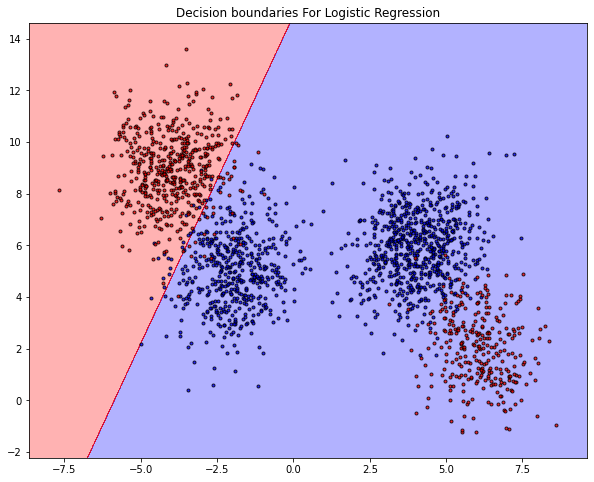

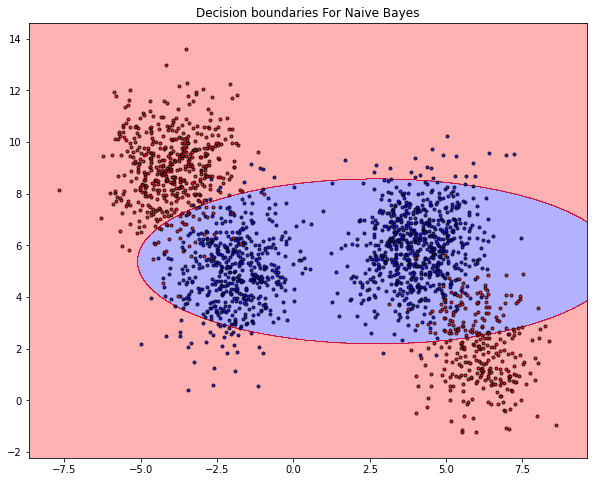

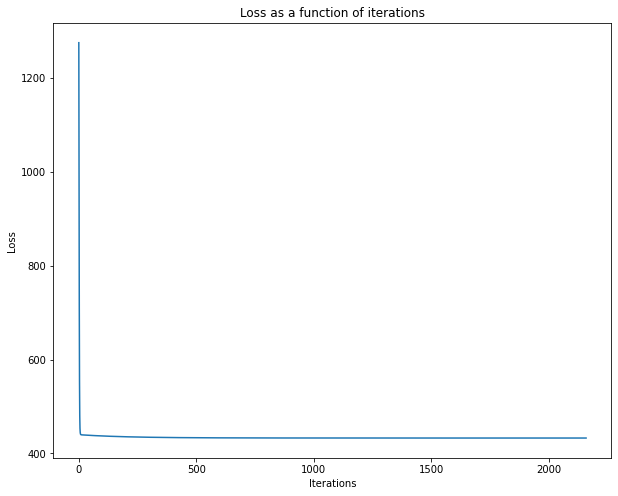

In [19]:
# whole data both the training data and the test data
# fit Logistic Regression model
LR = LogisticRegressionGD(eta=best_alpha, eps=best_eps)
LR.fit(X_training, y_training)

# fit Naive Bayes model
NB = NaiveBayesGaussian(k=2)
NB.fit(X_training, y_training)

# Logistic Regression -> accuracy evaluation (train)
train_acc_LG_all = accuracy_evaluation(X_training, y_training, LR)

# Logistic Regression -> accuracy evaluation (test)
test_acc_LG_all = accuracy_evaluation(X_test, y_test, LR)

# Naive Bayes -> accuracy evaluation (train)
train_acc_NB_all = accuracy_evaluation(X_training, y_training, NB)

# Naive Bayes -> accuracy evaluation (test)
test_acc_NB_all = accuracy_evaluation(X_test, y_test, NB)

print("Logistic Regression -> for the training data the accuracy is ", train_acc_LG_all, " for the test data the accuracy is ", test_acc_LG_all)
print("Naive Bayes -> for the training data the accuracy is ", train_acc_NB_all, " for the test data the accuracy is ", test_acc_NB_all)

# introduce diagrams for the whole data
# explanation: LOR always yields a linear separator, but our full data contains 4 gaussians which LOR cant separate properly.
plt.title("Decision boundaries For Logistic Regression")
plot_decision_regions(X_training, y_training, LR)
plt.figure()

# explanation: this time, as Naive bayes is capble of yielding a non-linear separator, it does better than LOR. all 4 gaussians are separated and classified accordingly
plt.title("Decision boundaries For Naive Bayes")
plot_decision_regions(X_training, y_training, NB)
plt.figure()

# explanation: We can observe that the loss is pretty high and stays that way regardless of the number of iterations. this is because LOR always yields a linear separator
# but our data cant be linearly separated properly so LOR quickly decreases its loss to the best it can (which is still worse than NB).
plt.plot(np.arange(len(LR.cost_list)), LR.cost_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss as a function of iterations')
plt.show()


## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####


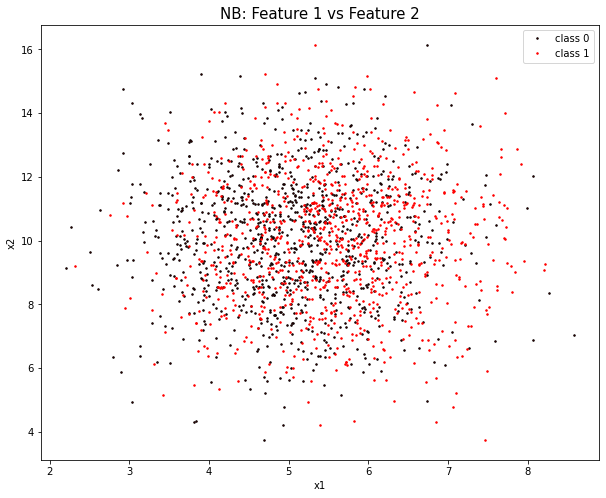

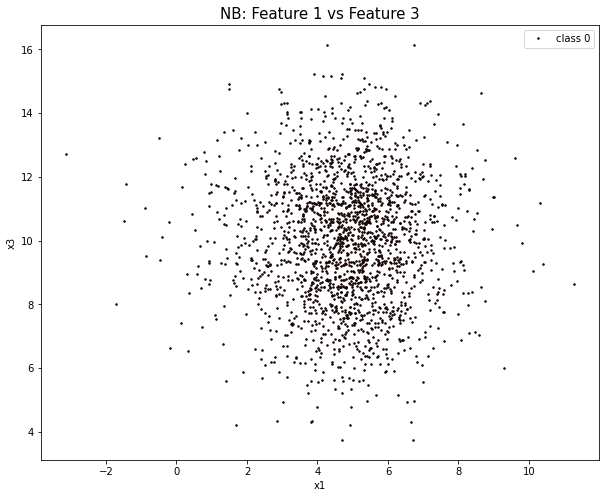

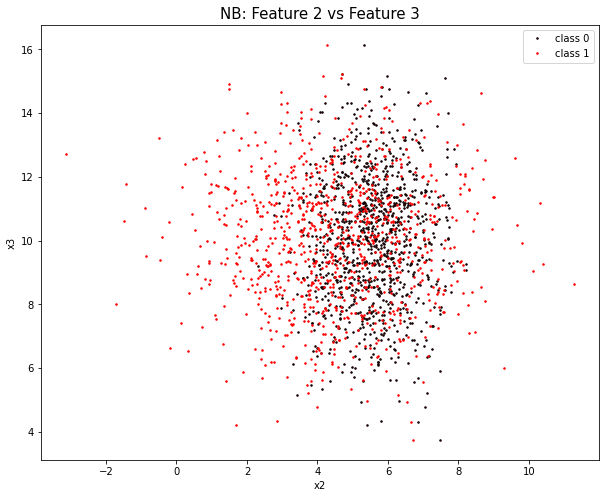

In [20]:
# First dataset
# We can see that our generated dataset fits to the naive bayes model - meaning we assume the points are conditionally independent.
# We can see from the graphs that LOR algorithm will do poorly because it cannot linearly separated the data. On the other hand
# NB should perform better as it fits the model.
# Note: We've colored points according to their class, so in the second graph, both gaussians share the same label.
x1 = np.random.normal(5, 1, 1000)
x2 = np.random.normal(5.5, 1, 1000)
x3 = np.random.normal(4.5, 2, 1000)
y = np.random.normal(10.0, 2.0, 1000)

plt.plot(x1, y, 'ro', ms=1.5, mec='k')
plt.plot(x2, y,'ro', ms=1.5)
plt.title("NB: Feature 1 vs Feature 2",fontsize = 15)
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(["class 0", "class 1"])

plt.figure()
plt.plot(np.append(x1, x3), np.append(y, y), 'ro', ms=1.5, mec='k')
plt.title("NB: Feature 1 vs Feature 3",fontsize = 15)
plt.ylabel('x3')
plt.xlabel('x1')
plt.legend(["class 0", "class 1"])

plt.figure()
plt.plot(x2, y, 'ro', ms=1.5, mec='k')
plt.plot(x3, y,'ro', ms=1.5)
plt.title("NB: Feature 2 vs Feature 3",fontsize = 15)
plt.ylabel('x3')
plt.xlabel('x2')
plt.legend(["class 0", "class 1"])

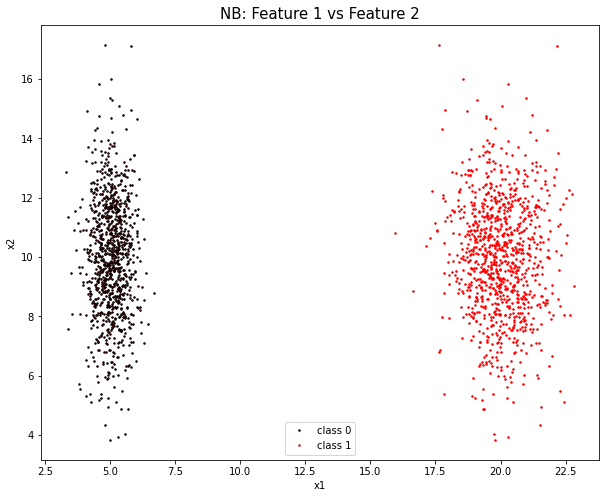

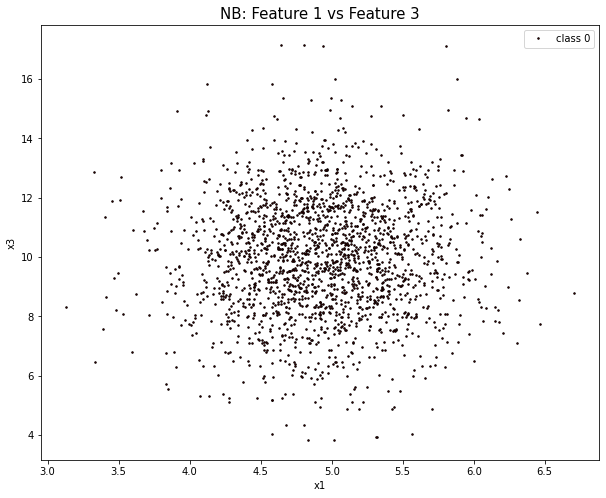

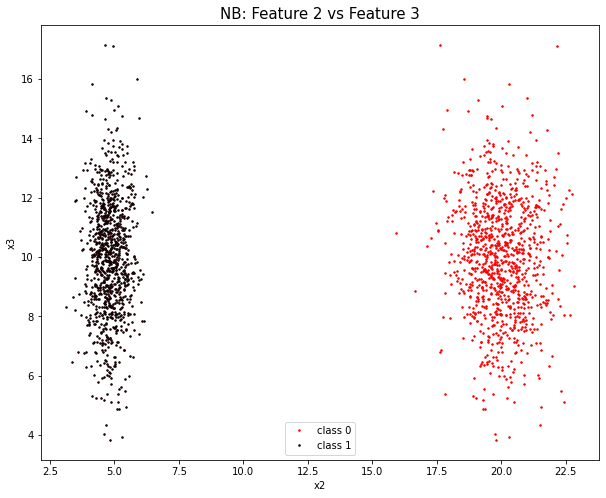

In [21]:
# Second dataset
# We believe that LOR algorithm will perform better than NB here. This is because we created a dateset that contains 3 features (x1, x2, x3) and 2 classes (0, 1 in y)
# which can be fully linearly seprable. As we've seen before, LOR yields a family of linear separators so it will converge with more percision than NB.
# Note: We've colored points according to their class, so in the second graph, both gaussians share the same label.

x1 = np.random.normal(5, 0.5, 1000)
x2 = np.random.normal(20, 1, 1000)
x3 = np.random.normal(4.8, 0.5, 1000)
y = np.random.normal(10.0, 2.0, 1000)

plt.plot(x1, y, 'ro', ms=1.5, mec='k')
plt.plot(x2, y,'ro', ms=1.5)
plt.title("NB: Feature 1 vs Feature 2",fontsize = 15)
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(["class 0", "class 1"])

plt.figure()
plt.plot(np.append(x1, x3), np.append(y, y), 'ro', ms=1.5, mec='k')
plt.title("NB: Feature 1 vs Feature 3",fontsize = 15)
plt.ylabel('x3')
plt.xlabel('x1')
plt.legend(["class 0", "class 1"])

plt.figure()
plt.plot(x2, y, 'ro', ms=1.5) 
plt.plot(x3, y,'ro', ms=1.5, mec='k')
plt.title("NB: Feature 2 vs Feature 3",fontsize = 15)
plt.ylabel('x3')
plt.xlabel('x2')
plt.legend(["class 0", "class 1"])